![Linux Academy](la-logo.png)
<hr/>
conda_amazonei_mxnet_p36


<center><h1>MXNet Basic Classification</h1></center>

![Sorting Lego bricks](./lego.jpg)

<center><h2>Lego Brick Sorting</h2></center>

# Introduction

In this Linux Academy hands-on lab we take an introductory look at __MXNet and Gluon__ and use it to make a simple artificial neural network.

## MXNet

A flexible and efficient library for deep learning.

- MXNet provides optimized numerical computation for GPUs and distributed ecosystems, from the comfort of high-level environments like Python and R.
- MXNet automates common workflows, so standard neural networks can be expressed concisely in just a few lines of code.

_(Source: https://mxnet.apache.org/)_

## Gluon

Based on the the Gluon API specification, the new Gluon library in Apache MXNet provides a clear, concise, and simple API for deep learning. It makes it easy to prototype, build, and train deep learning models without sacrificing training speed. Install the latest version of MXNet to get access to Gluon.

_(Source: https://mxnet.apache.org/versions/master/gluon/index.html)_


# Scenario

We have bricks, lots of brick. Lego bricks that is. And we need to sort them.

We have a collection of photos of different Lego bricks from different angles. We have 600 photos (really we do) and they are all labeled with the brick name.

Each photo has been processed. This involved increasing the contrast, sharpening, removing the color, inverting the colors, and reducing the size.

|![Sample Lego brick photo](./sample-before.png)|![Sample Lego brick photo](./sample-after.png)|
|----------------------------------------|----------------------------------------|
| Sample before processing                | Sample after processing                |

In addition to this, we loaded all the images into a single data array for easier loading into the algorithm.  If you're interested in how these images were collected and processed, contact me through the Linux Academy Community Slack: ```@mike chambers```.

We need to create a simple, deep learning, neural network classifier model. We will train the model using the photo data and see if it correctly predicts or infers the type of a brick from a supplied test image.

# How to Use This Lab

This is a follow-along lab. That is to say the code in this Jupyter Notebook should be complete, and you could simply execute the notebook to get a result. However, watch along with the video to learn more about what is happening in the code and then take the time to experiment with the code; make changes, break it, fix it, and learn!

# 1) The Libraries

In [1]:
import mxnet as mx
from mxnet.gluon.data.vision import transforms

from mxnet import nd, gluon, autograd
from mxnet.gluon import nn

import pickle # load

import numpy as np
import matplotlib.pyplot as plt

# Select a fixed random seed for reproducibility
mx.random.seed(42)

Before we get started, lets take a moment to set the processor type MXNet will use. This Juypter Notebook server doesn't have access to GPU's and we let MXNet discover that here. That will be okay for what we are doing.

In [2]:
ctx = mx.gpu(0) if mx.context.num_gpus() > 0 else mx.cpu(0) # default cpu; find available gpu

# 2) Load the data [numpy]

We have a dataset created from a set of photos of Lego bricks. In total we have 2 sets of data saved to files as NDArrays.

1. __lego-simple-mx-train__ - _Training images and labels combined, around 80% of the data collected._
2. __lego-simple-mx-test__ - _Testing or validation images and labels combined, around 20% of the data collected._

First we load the data into runtime arrays. ```Pickle``` has been used to create these object files, so we use ```pickle``` to load them as well.

In [3]:
# Open the files:
train_fh = open('lego-simple-mx-train', 'rb')
test_fh = open('lego-simple-mx-test', 'rb')

# Use pickle to load files into runtime objects:
train_data = pickle.load(train_fh)
test_data = pickle.load(test_fh)

In [4]:
train_fh

<_io.BufferedReader name='lego-simple-mx-train'>

In [7]:
print(train_data[0]) # NDArrays

(
[[[ 9]
  [ 9]
  [ 9]
  ...
  [ 9]
  [ 9]
  [ 9]]

 [[ 9]
  [ 9]
  [ 9]
  ...
  [ 9]
  [ 9]
  [ 9]]

 [[ 9]
  [ 9]
  [ 9]
  ...
  [ 9]
  [ 9]
  [ 9]]

 ...

 [[14]
  [14]
  [14]
  ...
  [14]
  [14]
  [14]]

 [[15]
  [15]
  [15]
  ...
  [15]
  [15]
  [15]]

 [[14]
  [14]
  [14]
  ...
  [14]
  [14]
  [14]]]
<NDArray 48x48x1 @cpu(0)>, 4)


The label data we loaded are integer values (1,2,3). We want human names for the data classes we're working with.

In [8]:
# For humans:
class_names = ['2x3 Brick', '2x2 Brick', '1x3 Brick', '2x1 Brick', '1x1 Brick', '2x2 Macaroni', '2x2 Curved End', 'Cog 16 Tooth', '1x2 Handles', '1x2 Grill']

# Or the real Lego codes:
# class_names = ['3002', '3003', '3622', '3004', '3005', '3063', '47457', '94925', '3839a', '2412b']

## Convert to MXNet Tensors

We have the data loaded into NDArrays. Now we transfer the data into MXNet tensors.

Tensors act like arrays but with extra capability. 

In [9]:
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.13, 0.31)])

train_data = train_data.transform_first(transformer)
test_data = test_data.transform_first(transformer)

In [10]:
train_data

The data is loaded but it's nice to see it. Let's take a look at one of the images loaded with the data.

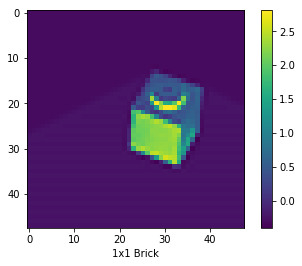

In [11]:
train_image_no = 0

images_data, label_data = train_data[train_image_no]
plt.figure()
plt.imshow(images_data.reshape((48,48)).asnumpy())
plt.colorbar()
plt.xlabel(class_names[label_data])
plt.show()

Let's look at some more of the data and make the formating a little nicer.

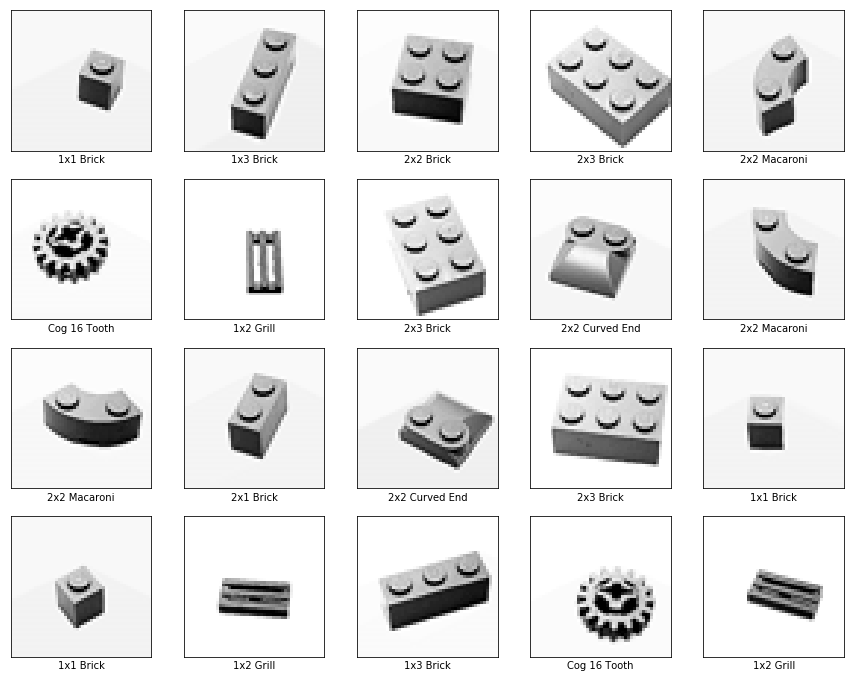

In [12]:
plt.figure(figsize=(15,15))
for i in range(20):
    images_data, label_data = train_data[i]
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(images_data.reshape((48,48)).asnumpy(), cmap=plt.cm.binary)
    plt.xlabel(class_names[label_data])
plt.show()

# 3) Training [MXNet Gluon]¶

Now the data is loaded, so let's start training. First, we need to create a model. With MXNet we often call the model object ```net```. We are creating an artificial neural network. It has 4 layers:

1. The input layer with enough nodes for our image data.
2. A hidden layer with 128 nodes and ReLU activation.
3. A hidden layer with 64 nodes and ReLU activation.
4. An output layer with 10 nodes, one for each of the classes we want to identify.

Each layer is densely connected, meaning that each neuron in one layer is connected to every neuron in the next layer.

In [13]:
net = nn.HybridSequential(prefix='MLP_')
with net.name_scope():
    net.add(
        nn.Flatten(), 
        nn.Dense(128, activation='relu'), # hidden layer 1
        nn.Dense(64, activation='relu'), # hidden layer 2
        nn.Dense(10, activation=None) # total of 10 classes
    )

MXNet Gluon provides data loaders we can use to simplify the loading of data when training our model. Let's set them up.

In [14]:
batch_size = 34  #DataLoader
train_loader = mx.gluon.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)

Initializing the model. Note we pass in the variable holding the processor type here.

In [15]:
net.initialize(mx.init.Xavier(), ctx=ctx) # if needed, mx will see the available gpu

Gluon provides a trainer object to maintain the state of the training. We create it here, and use it in the training process.

In [16]:
trainer = gluon.Trainer(
    params=net.collect_params(),
    optimizer='sgd',
    optimizer_params={'learning_rate': 0.04},
)

We're almost ready to train. First, we define the metric to use while we train and the loss function to use. Gluon provides a softmax loss function, so we just use that.

In [17]:
metric = mx.metric.Accuracy()
loss_function = gluon.loss.SoftmaxCrossEntropyLoss()

Now we train. We could write the following code into a ```fit``` function, but this inline code does the job.

In [18]:
num_epochs = 10
history = []
    
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        # Possibly copy inputs and labels to the GPU
        inputs = inputs.as_in_context(ctx)
        labels = labels.as_in_context(ctx)

        # Forward pass
        with autograd.record():
            outputs = net(inputs)
            loss = loss_function(outputs, labels)

        # Backpropagation
        loss.backward()
        metric.update(labels, outputs)

        # Update
        trainer.step(batch_size=inputs.shape[0])

    # Print the evaluation metric and reset it for the next epoch
    name, acc = metric.get()
    history.insert(epoch,acc)
    print('.', end='')
    metric.reset()

print('[Done]')

..........[Done]


In [29]:
history

[0.34811529933481156,
 0.7738359201773836,
 0.9201773835920177,
 0.9556541019955654,
 0.9822616407982262,
 0.9933481152993349,
 0.9955654101995566,
 0.9889135254988913,
 0.9977827050997783,
 1.0]

During the training loop we collected accuracy data in each epoch. Let's graph this data to get a sense of how the training went.

Text(0.5, 0, 'Epoch')

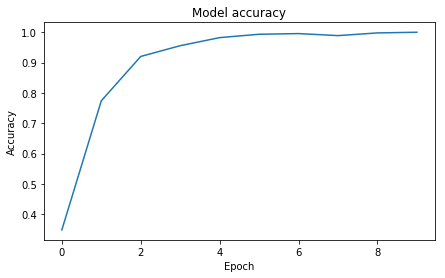

In [19]:
plt.figure(figsize=(7, 4))
plt.plot(history)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

# 4) Evaluate

Now, we use the test data to perform an accuracy measurement. Is the accuracy with the testing data much lower than the end of training? If so our model might be overfit.  

We use the Gluon data loader again, this time with the test data.

In [20]:
test_loader = mx.gluon.data.DataLoader(test_data, shuffle=False, batch_size=batch_size)

And measure the accuracy.

In [21]:
metric = mx.metric.Accuracy()
for inputs, labels in test_loader:
    # Possibly copy inputs and labels to the GPU
    inputs = inputs.as_in_context(ctx)
    labels = labels.as_in_context(ctx)
    metric.update(labels, net(inputs))
print('Validaton: {} = {}'.format(*metric.get()))

Validaton: accuracy = 0.9733333333333334


# 5) Test

In order to make our tests look good, we define a couple of functions to dispaly the results.

In [22]:
# Function to display the image:
def plot_image(predictions_array, true_label, img):
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img.reshape((48,48)).asnumpy(), cmap=plt.cm.binary)
  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'green'
  else:
    color = 'red'
  # Print a label with 'predicted class', 'probability %', 'actual class'
  plt.xlabel("{} [{:2.0f}] ({})".format(class_names[predicted_label],
                                np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

# Function to display the prediction results in a graph:
def plot_value_array(predictions_array, true_label):
  plt.xticks(range(10))
  plt.yticks([])
  plot = plt.bar(range(10), predictions_array, color="#777777")
  predicted_label = np.argmax(predictions_array)
  plot[predicted_label].set_color('red')
  plot[true_label].set_color('green')

## Single Prediction

Let's test out model. Choose one of the images from our test set.

In [23]:
prediction_image_number = 25

Now make a prediction.

In [24]:
prediction_image, prediction_label = test_data[prediction_image_number]
predictions_single = net(prediction_image)
predictions_single


[[-2.4691582  -1.6704586   7.1950994  -5.347214   -5.371027    3.6394851
  -0.85591376  2.483347   -2.1135633  -5.4215045 ]]
<NDArray 1x10 @cpu(0)>

Let's display those results with our function defined earlier.

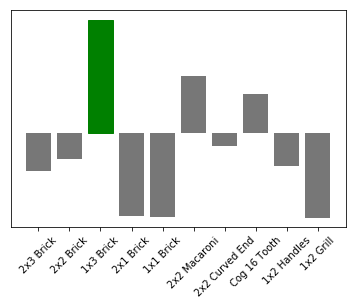

In [25]:
plot_value_array(predictions_single[0].asnumpy(), prediction_label)
plt.xticks(range(10), class_names, rotation=45)
plt.show()

And which block should we have found? In other words, did we get it right?

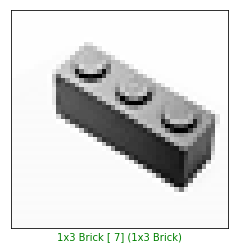

In [26]:
plot_image(predictions_single[0].asnumpy(), prediction_label, prediction_image)

## Batch Prediction

Now lets get prediction values for **all** the test images we have. This time we don't use a data loader, we just iterate through the raw test image data.

In [27]:
predictions = []
test_labels = []

for i in test_data:
    pred_image, pred_label = i
    p = net(pred_image)
    predictions.append(p)
    test_labels.append(pred_label)    

Finally, let's use our helper functions to summarize the first 16 images in our test data. How did we do?

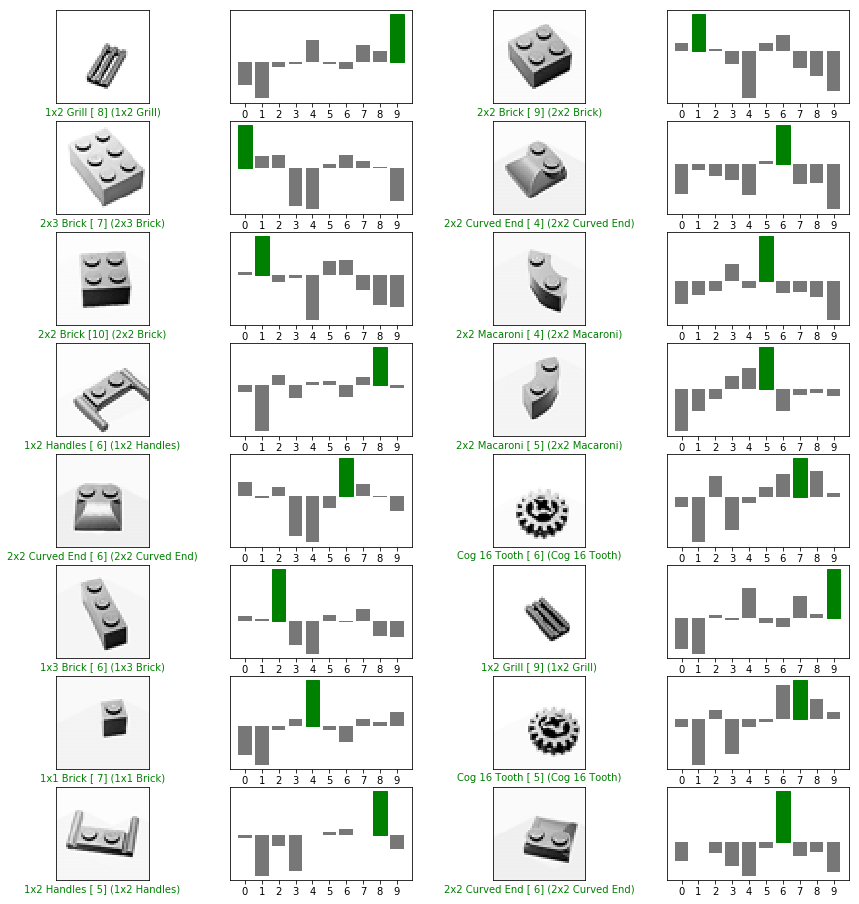

In [28]:
num_rows = 8
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(15, 16))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(predictions[i].asnumpy(), test_data[i][1], test_data[i][0])
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(predictions[i][0].asnumpy(), test_data[i][1])
plt.show()

That is the end of this Linux Academy hands-on lab. Thanks!